# Making infection chain graphs from Delineo Simulator Data

In [6]:
# Generate clean infection chain analysis for simulation data

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import defaultdict, deque
from matplotlib.colors import LinearSegmentedColormap


# Read the CSV file
df = pd.read_csv("../data/raw/sample_2/infection_logs.csv")
print(f"Total infections: {len(df)}")

# Basic statistics
initial_infections = df['infector_person_id'].isna().sum()
print(f"Initial seed infections: {initial_infections}")
print(f"Secondary infections: {len(df) - initial_infections}")




Total infections: 381
Initial seed infections: 2
Secondary infections: 379


In [7]:
# 1. INFECTION GENERATION ANALYSIS WITH CYCLE DETECTION AND REMOVAL
print("\n=== GENERATION ANALYSIS WITH CYCLE DETECTION ===")
G = nx.DiGraph()

# First pass: Build initial graph and detect cycles
temp_G = nx.DiGraph()
for _, row in df.iterrows():
    infector = row['infector_person_id']
    infected = row['infected_person_id']
    
    if pd.isna(infector):
        infector = 'SEED'
    
    temp_G.add_edge(infector, infected)

# Detect cycles in the graph
cycles = list(nx.simple_cycles(temp_G))
print(f"Found {len(cycles)} cycles in the data")

# Identify edges that participate in cycles
cycle_edges = set()
for cycle in cycles:
    for i in range(len(cycle)):
        current = cycle[i]
        next_node = cycle[(i + 1) % len(cycle)]
        cycle_edges.add((current, next_node))

print(f"Total edges participating in cycles: {len(cycle_edges)}")

# Remove cycle edges from the temporary graph
edges_to_remove = []
for edge in cycle_edges:
    if temp_G.has_edge(edge[0], edge[1]):
        edges_to_remove.append(edge)

print(f"Removing {len(edges_to_remove)} cycle edges")
temp_G.remove_edges_from(edges_to_remove)

# Verify the graph is now acyclic
remaining_cycles = list(nx.simple_cycles(temp_G))
print(f"Remaining cycles after removal: {len(remaining_cycles)}")

# Calculate generations using BFS on cycle-free graph
from collections import deque

generations = {}
queue = deque([('SEED', 0)])
generations['SEED'] = 0

while queue:
    node, gen = queue.popleft()
    for successor in temp_G.successors(node):
        if successor not in generations:
            generations[successor] = gen + 1
            queue.append((successor, gen + 1))

# Handle nodes that became unreachable after cycle removal
unreachable_nodes = set()
for node in temp_G.nodes():
    if node not in generations:
        unreachable_nodes.add(node)

print(f"Nodes that became unreachable after cycle removal: {len(unreachable_nodes)}")

# Find the maximum generation
if any(person != 'SEED' for person in generations.keys()):
    max_generation = max(gen for person, gen in generations.items() if person != 'SEED')
    print(f"Maximum generation: {max_generation}")
else:
    max_generation = 0
    print("No generations found beyond SEED")

# Second pass: Build final graph excluding edges from last generation
for _, row in df.iterrows():
    infector = row['infector_person_id']
    infected = row['infected_person_id']
    
    if pd.isna(infector):
        infector = 'SEED'
    
    # Skip if this edge was removed due to cycle detection
    if (infector, infected) in cycle_edges:
        print(f"Skipping cycle edge: {infector} -> {infected}")
        continue
    
    # Only add edge if infector is not from the last generation
    infector_gen = generations.get(infector, -1)  # -1 for unreachable nodes
    if infector_gen >= 0 and infector_gen < max_generation:
        G.add_edge(infector, infected)
    else:
        # Still add the infected person as a node (they exist, just don't infect others)
        G.add_node(infected)

print(f"Sample generations: {dict(list(generations.items())[:10])}")

# Debug: Check if we have any nodes
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Nodes connected to SEED: {list(G.successors('SEED'))[:5]}")

# Verify the final graph is acyclic
final_cycles = list(nx.simple_cycles(G))
print(f"Cycles in final graph: {len(final_cycles)}")

# Verify last generation has no outgoing edges
if max_generation > 0:
    last_gen_people = [person for person, gen in generations.items() 
                       if gen == max_generation - 1 and person != 'SEED']
    last_gen_with_successors = [person for person in last_gen_people 
                               if len(list(G.successors(person))) > 0]

    print(f"People in last generation: {len(last_gen_people)}")
    print(f"Last generation people with outgoing edges: {len(last_gen_with_successors)}")

# Count by generation
gen_counts = defaultdict(int)
for person, gen in generations.items():
    if person != 'SEED':
        gen_counts[gen] += 1

print(f"Generation counts: {dict(gen_counts)}")

print("Infections by generation:")
for gen in sorted(gen_counts.keys()):
    print(f"Generation {gen}: {gen_counts[gen]} people")

# Report on unreachable nodes
if unreachable_nodes:
    print(f"\nUnreachable nodes after cycle removal: {len(unreachable_nodes)}")
    print(f"Sample unreachable nodes: {list(unreachable_nodes)[:5]}")

# Add generation info to dataframe for later use
# Use -1 for unreachable nodes after cycle removal
df['infector_generation'] = df['infector_person_id'].map(lambda x: generations.get(x, -1))
df['infected_generation'] = df['infected_person_id'].map(lambda x: generations.get(x, -1))

# Flag rows that were affected by cycle removal
df['cycle_edge_removed'] = df.apply(
    lambda row: (row['infector_person_id'] if not pd.isna(row['infector_person_id']) else 'SEED', 
                 row['infected_person_id']) in cycle_edges, axis=1
)

print(f"\nRows affected by cycle removal: {df['cycle_edge_removed'].sum()}")
print(f"Rows with unreachable nodes: {((df['infector_generation'] == -1) | (df['infected_generation'] == -1)).sum()}")

# Summary statistics
print("\n=== CYCLE REMOVAL SUMMARY ===")
print(f"Original edges: {len(df)}")
print(f"Cycles found: {len(cycles)}")
print(f"Cycle edges removed: {len(cycle_edges)}")
print(f"Nodes became unreachable: {len(unreachable_nodes)}")
print(f"Final graph is acyclic: {len(final_cycles) == 0}")
print(f"Maximum generation depth: {max_generation}")


=== GENERATION ANALYSIS WITH CYCLE DETECTION ===
Found 43 cycles in the data
Total edges participating in cycles: 43
Removing 43 cycle edges
Remaining cycles after removal: 0
Nodes that became unreachable after cycle removal: 97
Maximum generation: 4
Skipping cycle edge: 4.0 -> 39
Skipping cycle edge: 4.0 -> 65
Skipping cycle edge: 65.0 -> 4
Skipping cycle edge: 11.0 -> 69
Skipping cycle edge: 32.0 -> 16
Skipping cycle edge: 62.0 -> 32
Skipping cycle edge: 39.0 -> 9
Skipping cycle edge: 20.0 -> 12
Skipping cycle edge: 65.0 -> 55
Skipping cycle edge: 55.0 -> 65
Skipping cycle edge: 1.0 -> 18
Skipping cycle edge: 35.0 -> 46
Skipping cycle edge: 2.0 -> 48
Skipping cycle edge: 36.0 -> 27
Skipping cycle edge: 32.0 -> 65
Skipping cycle edge: 18.0 -> 46
Skipping cycle edge: 12.0 -> 24
Skipping cycle edge: 69.0 -> 16
Skipping cycle edge: 48.0 -> 64
Skipping cycle edge: 64.0 -> 3
Skipping cycle edge: 24.0 -> 20
Skipping cycle edge: 35.0 -> 15
Skipping cycle edge: 35.0 -> 24
Skipping cycle edge

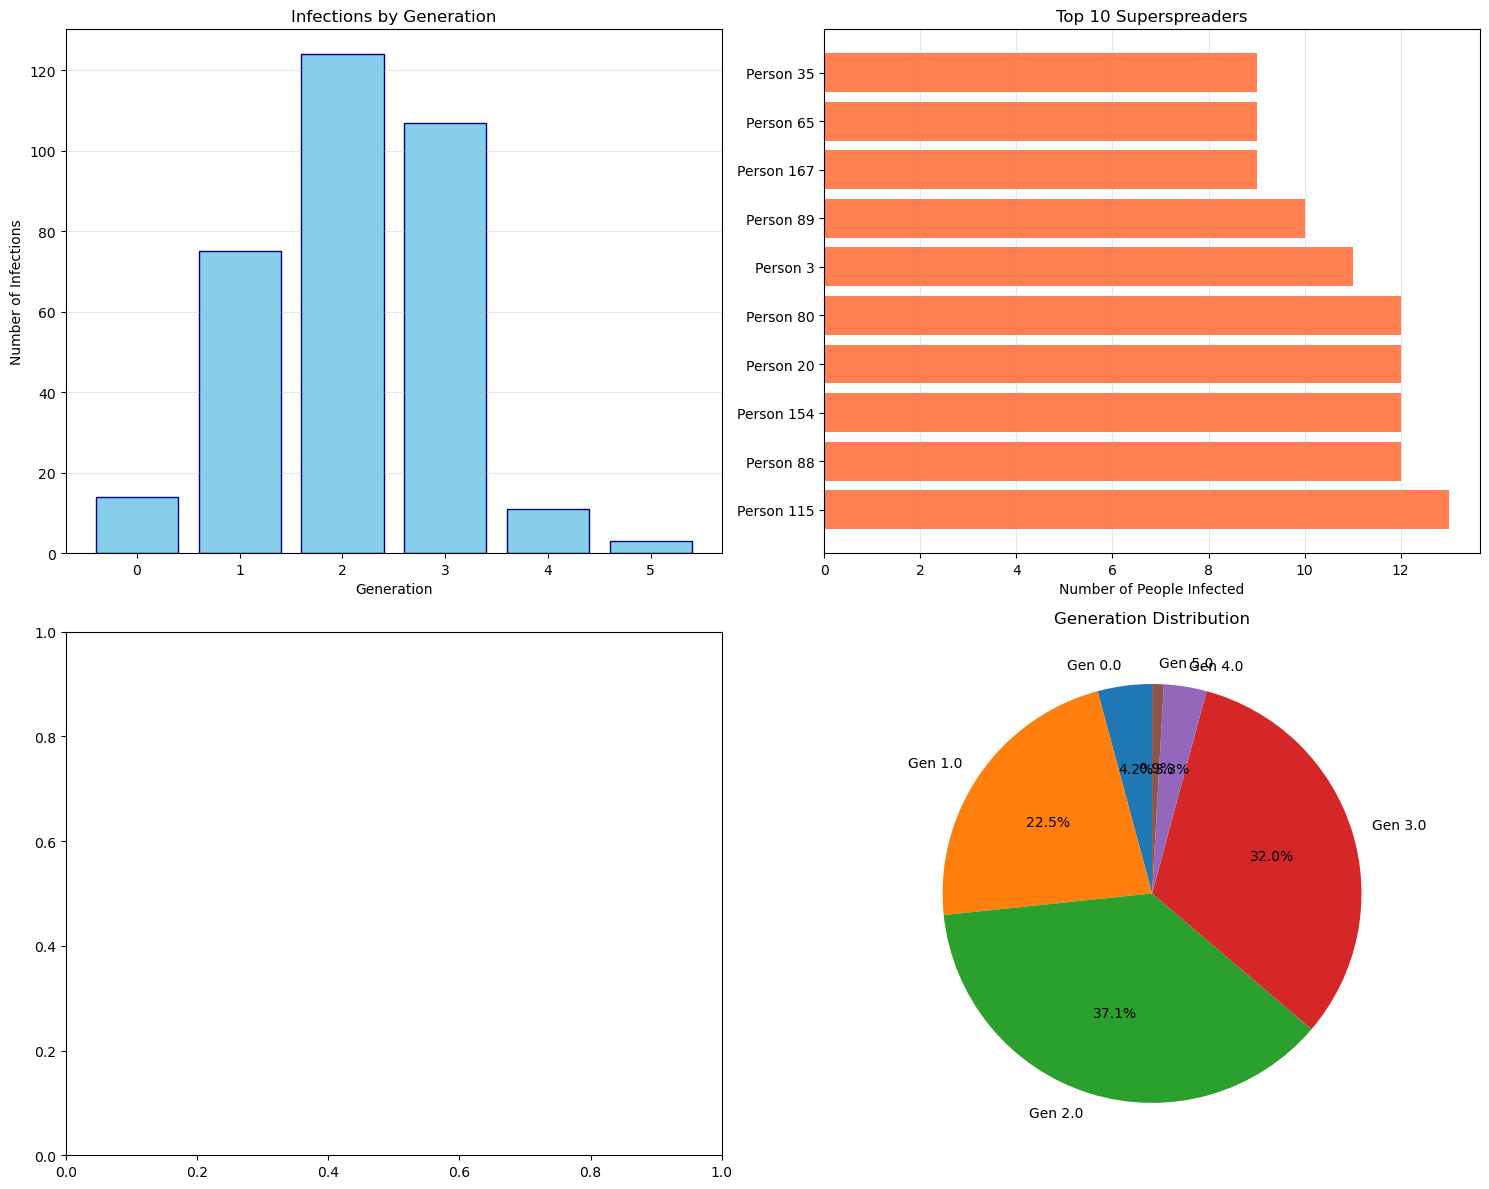

In [8]:
# 2. VISUALIZATION: Generation bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Compute generation for each infection
# Build a mapping from infected_person_id to infector_person_id
infected_to_infector = dict(zip(df['infected_person_id'], df['infector_person_id']))

# Initialize generations: seeds (no infector) are generation 0
generations = {}
for idx, row in df.iterrows():
    if pd.isna(row['infector_person_id']):
        generations[row['infected_person_id']] = 0

# BFS to assign generations
queue = list(generations.keys())
while queue:
    current = queue.pop(0)
    current_gen = generations[current]
    # Find all people infected by current
    children = df[df['infector_person_id'] == current]['infected_person_id'].tolist()
    for child in children:
        if child not in generations:
            generations[child] = current_gen + 1
            queue.append(child)

# Add generation column to df
df['generation'] = df['infected_person_id'].map(generations)

# Count infections per generation
gen_counts = df['generation'].value_counts().sort_index()

# Generation distribution
if len(gen_counts) > 0:
    gens = list(gen_counts.index)
    counts = [gen_counts.get(g, 0) for g in gens]
    ax1.bar(gens, counts, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Number of Infections')
    ax1.set_title('Infections by Generation')
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No generation data found\nCheck your data structure', 
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('Infections by Generation - No Data')

# 3. Top superspreaders
infector_counts = df.groupby('infector_person_id').size().sort_values(ascending=False)
infector_counts = infector_counts.dropna()  # Remove NaN (initial seeds)

if len(infector_counts) > 0:
    top_spreaders = infector_counts.head(10)
    ax2.barh(range(len(top_spreaders)), top_spreaders.values, color='coral')
    ax2.set_yticks(range(len(top_spreaders)))
    ax2.set_yticklabels([f'Person {int(id)}' for id in top_spreaders.index])
    ax2.set_xlabel('Number of People Infected')
    ax2.set_title('Top 10 Superspreaders')
    ax2.grid(axis='x', alpha=0.3)


# 4. Infection timeline (if timestamp available)
if 'timestamp' in df.columns:
    time_col = 'timestamp'
    daily_infections = df.groupby(time_col).size()
    ax4.plot(daily_infections.index, daily_infections.values, marker='o', linewidth=2, markersize=4)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('New Infections')
    ax4.set_title('Infection Timeline')
    ax4.grid(alpha=0.3)
else:
    # Show distribution of generation sizes as pie chart
    ax4.pie(counts, labels=[f'Gen {g}' for g in gens], autopct='%1.1f%%', startangle=90)
    ax4.set_title('Generation Distribution')

plt.tight_layout()
plt.show()

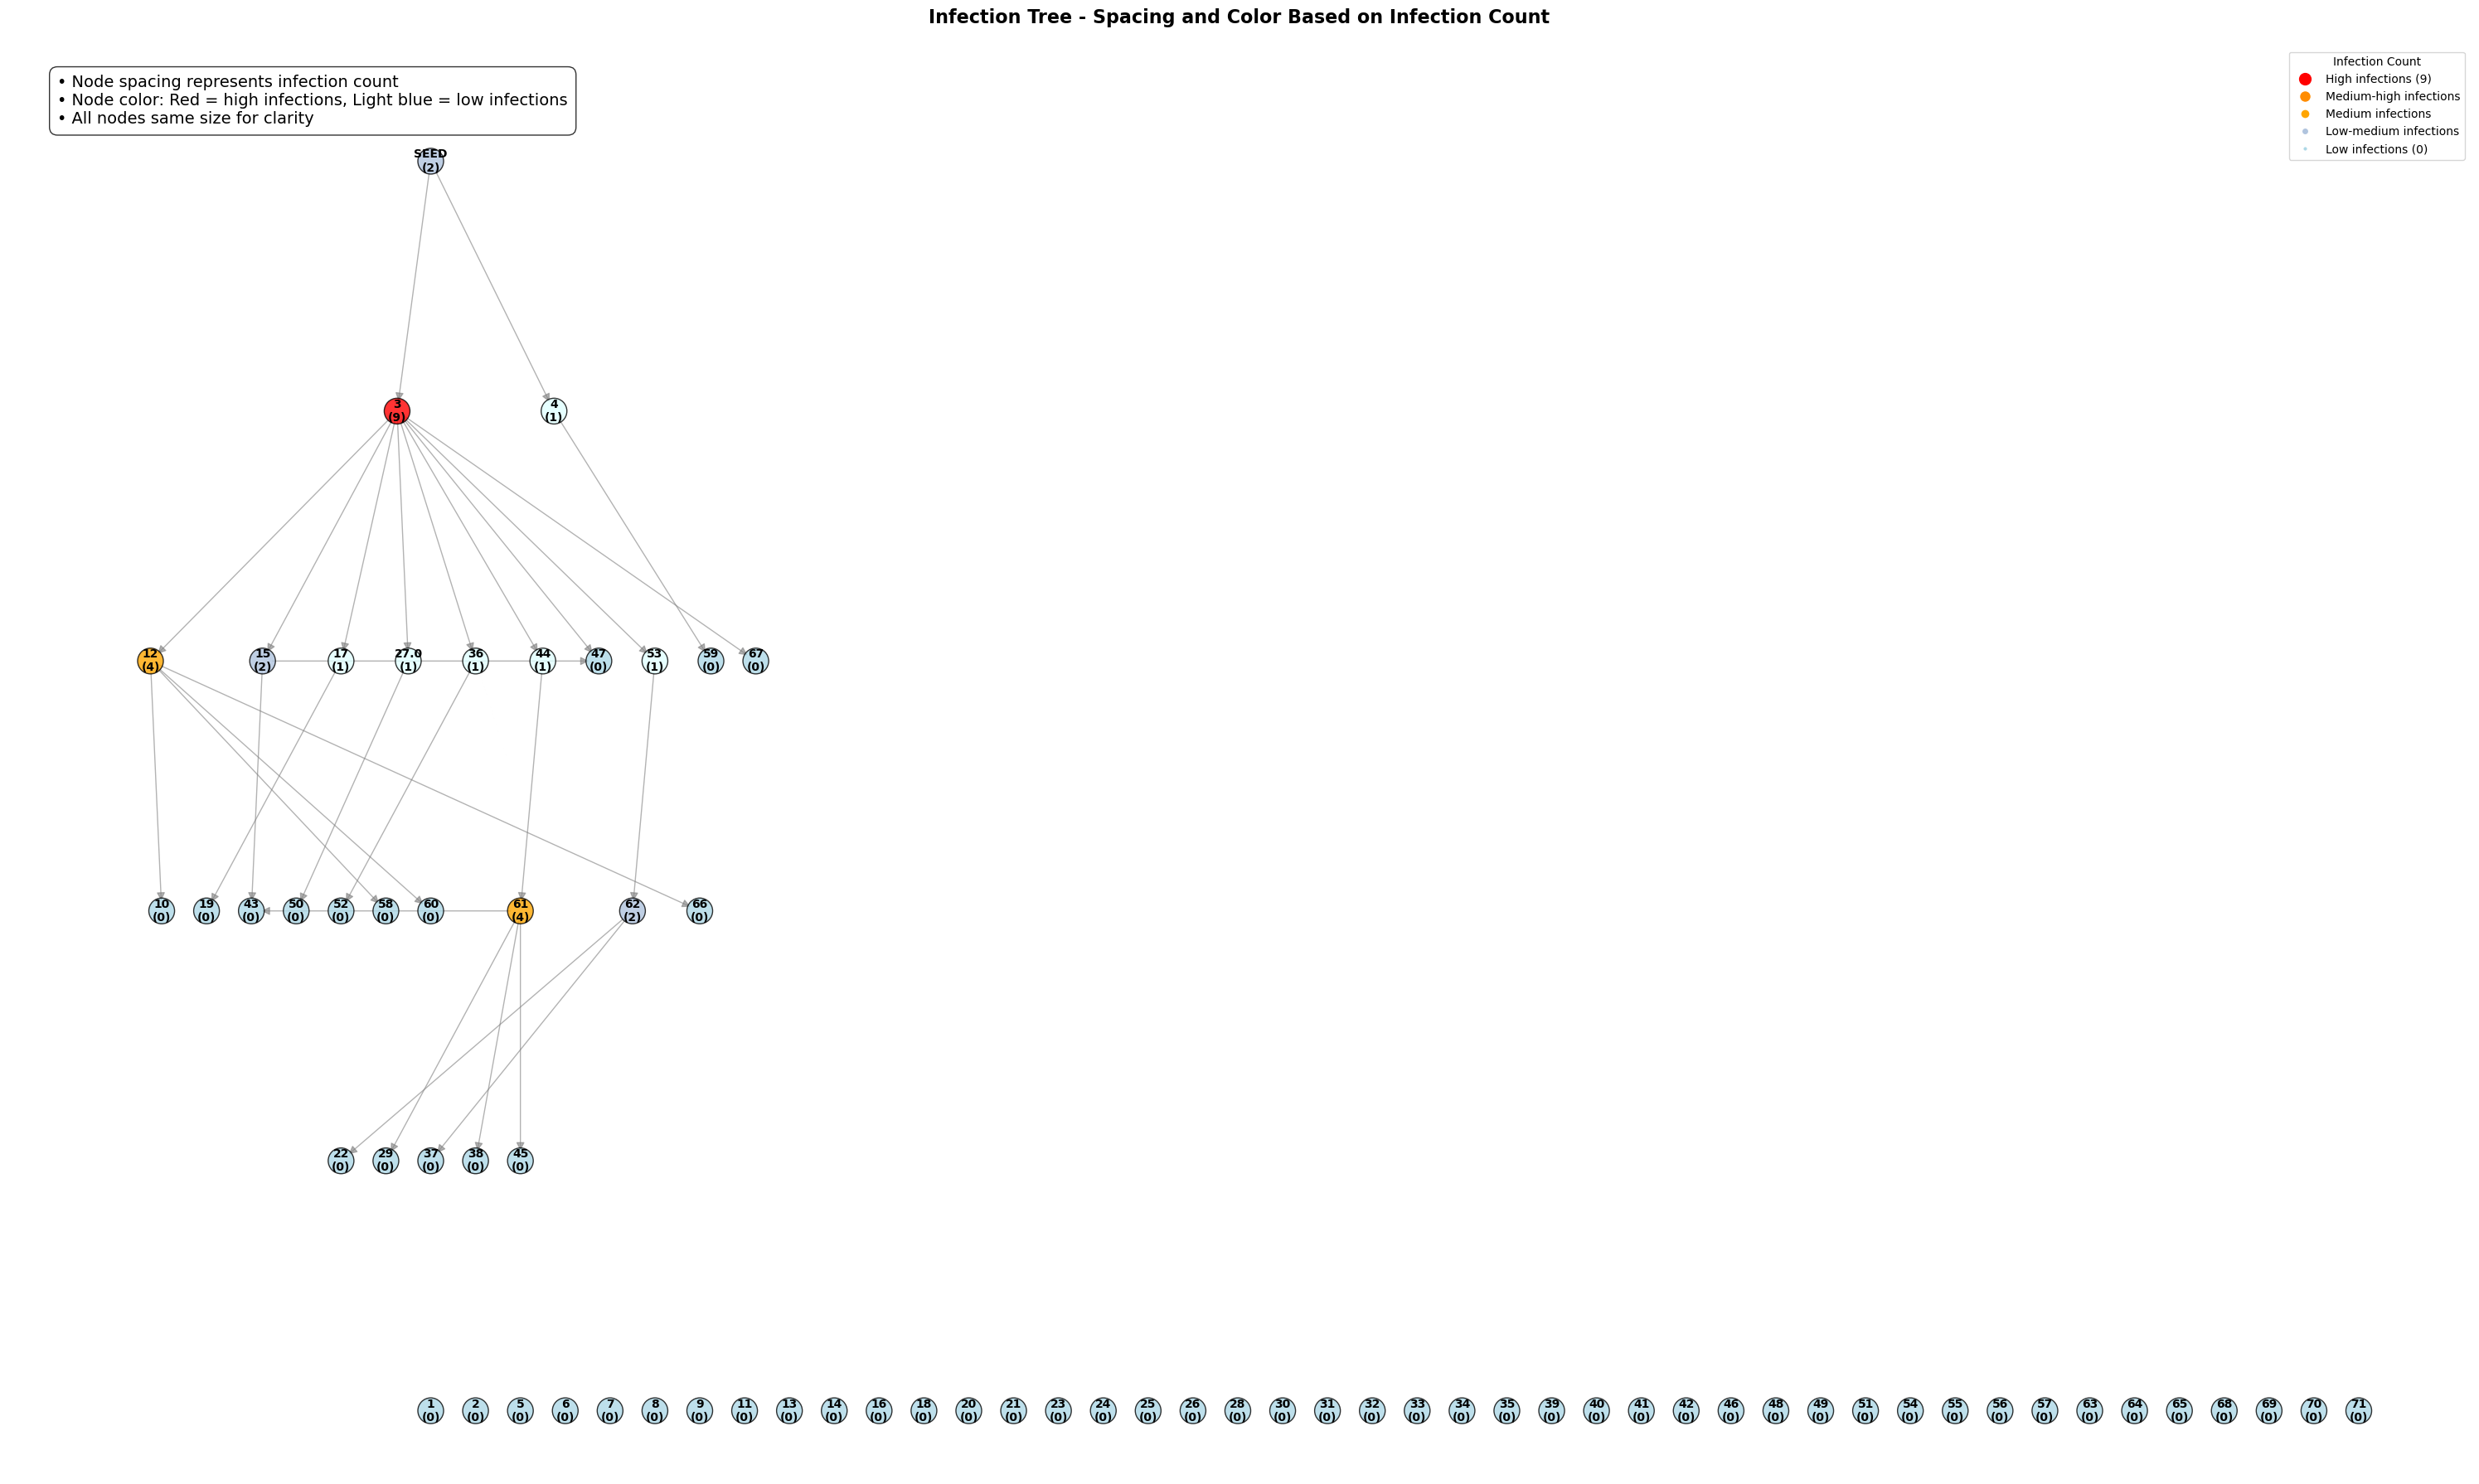

Infection Statistics:
Max infections by single node: 9
Total nodes: 72
Nodes with infections: 12


In [9]:
def create_infection_weighted_layout(G, root='SEED', base_spacing=8.0, infection_multiplier=3.0):
    """
    Generate a tree layout where spacing is proportional to infection count.
    
    Parameters:
    - G: NetworkX DiGraph
    - root: Root node (default 'SEED')
    - base_spacing: Minimum spacing between nodes
    - infection_multiplier: How much to scale spacing based on infection count
    """
    # Build generations
    generations = {}
    queue = deque([(root, 0)])
    generations[root] = 0

    while queue:
        node, gen = queue.popleft()
        for child in G.successors(node):
            if child not in generations:
                generations[child] = gen + 1
                queue.append((child, gen + 1))

    # Group by level
    level_nodes = defaultdict(list)
    for node, gen in generations.items():
        level_nodes[gen].append(node)

    # Calculate infection counts (out-degree)
    infection_counts = {}
    for node in G.nodes():
        infection_counts[node] = G.out_degree(node)

    # Compute positions with infection-weighted spacing
    pos = {}
    max_gen = max(generations.values()) if generations else 0

    for gen in range(max_gen + 1):
        nodes = sorted(level_nodes[gen], key=lambda x: str(x))
        
        if len(nodes) == 1:
            # Single node - center it
            pos[nodes[0]] = (0, -gen * 5)
            continue

        # Calculate spacing based on infection counts
        node_spacings = []
        for node in nodes:
            infection_count = infection_counts[node]
            # Base spacing + additional spacing based on infections
            spacing = base_spacing + (infection_count * infection_multiplier)
            node_spacings.append(spacing)

        # Calculate positions to center the level
        total_width = sum(node_spacings)
        start_x = -total_width / 2

        current_x = start_x
        for i, node in enumerate(nodes):
            if i == 0:
                # First node
                pos[node] = (current_x + node_spacings[i]/2, -gen * 5)
                current_x += node_spacings[i]
            else:
                # Subsequent nodes
                current_x += node_spacings[i]/2
                pos[node] = (current_x, -gen * 5)
                current_x += node_spacings[i]/2

    # Handle disconnected nodes
    all_nodes = set(G.nodes())
    missing = all_nodes - set(pos.keys())
    if missing:
        y = -(max_gen + 1) * 5
        for i, node in enumerate(sorted(missing)):
            pos[node] = (i * base_spacing, y)

    return pos, infection_counts

def get_infection_color(infection_count, max_infections):
    """
    Get color based on infection count - red for high, light blue for low.
    """
    if max_infections == 0:
        return 'lightblue'
    
    # Normalize infection count to 0-1 range
    normalized = infection_count / max_infections
    
    # Create color map from light blue (low) to red (high)
    if normalized == 0:
        return 'lightblue'
    elif normalized < 0.2:
        return 'lightcyan'
    elif normalized < 0.4:
        return 'lightsteelblue'
    elif normalized < 0.6:
        return 'orange'
    elif normalized < 0.8:
        return 'darkorange'
    else:
        return 'red'

# Create the visualization
def plot_infection_weighted_graph(G, base_spacing=10.0, infection_multiplier=5.0):
    """
    Plot the infection graph with weighted spacing and color coding.
    """
    # Create layout
    pos, infection_counts = create_infection_weighted_layout(G, 'SEED', base_spacing, infection_multiplier)
    
    # Get max infections for color scaling
    max_infections = max(infection_counts.values()) if infection_counts else 1
    
    # Create figure
    plt.figure(figsize=(30, 18))
    
    # Prepare node colors - keep constant size
    node_colors = []
    
    for node in G.nodes():
        infection_count = infection_counts[node]
        
        # Color based on infection count
        color = get_infection_color(infection_count, max_infections)
        node_colors.append(color)
    
    # Draw nodes with constant size
    nx.draw_networkx_nodes(G, pos, 
                           node_color=node_colors,
                           node_size=500,  # Fixed size
                           alpha=0.8,
                           edgecolors='black',
                           linewidths=1)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                           edge_color='gray',
                           arrows=True,
                           arrowsize=15,
                           alpha=0.6,
                           width=1)
    
    # Create labels with infection counts
    labels = {}
    for node in G.nodes():
        infection_count = infection_counts[node]
        if node == 'SEED':
            labels[node] = f"SEED\n({infection_count})"
        else:
            labels[node] = f"{node}\n({infection_count})"
    
    # Draw labels
    nx.draw_networkx_labels(G, pos,
                            labels=labels,
                            font_size=10,
                            font_weight='bold',
                            font_color='black')
    
    # Title
    plt.title("Infection Tree - Spacing and Color Based on Infection Count", 
              fontsize=16, fontweight='bold', pad=20)
    
    # Create custom legend for colors
    legend_elements = []
    
    # Color legend
    if max_infections > 0:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                       markersize=12, label=f'High infections ({max_infections})'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', 
                       markersize=10, label=f'Medium-high infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
                       markersize=8, label=f'Medium infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightsteelblue', 
                       markersize=6, label=f'Low-medium infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                       markersize=4, label=f'Low infections (0)')
        ])
    
    plt.legend(handles=legend_elements, loc='upper right', title='Infection Count')
    
    # Add explanation text
    plt.text(0.02, 0.98, 
             "• Node spacing represents infection count\n• Node color: Red = high infections, Light blue = low infections\n• All nodes same size for clarity", 
             transform=plt.gca().transAxes, fontsize=14, 
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print infection statistics
    print(f"Infection Statistics:")
    print(f"Max infections by single node: {max_infections}")
    print(f"Total nodes: {len(G.nodes())}")
    print(f"Nodes with infections: {sum(1 for count in infection_counts.values() if count > 0)}")

plot_infection_weighted_graph(G, base_spacing=10.0, infection_multiplier=5.0)


In [10]:
print(f"\n=== SUMMARY ===")
print(f"Total people infected: {len(df)}")
print(f"Initial seeds: {initial_infections}")
if len(infector_counts) > 0:
    print(f"Biggest superspreader infected: {infector_counts.iloc[0]} people")
    print(f"Average infections per spreader: {infector_counts.mean():.1f}")


=== SUMMARY ===
Total people infected: 381
Initial seeds: 2
Biggest superspreader infected: 13 people
Average infections per spreader: 3.9
